In [1]:
from dotenv import load_dotenv

load_dotenv()  # loads variables from .env into environment

True

In [2]:
# from indexing_pipeline import graph

# response = graph.invoke({"question": "What is Task Decomposition?"})
# print(response["answer"])

In [3]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

USER_AGENT environment variable not set, consider setting it to identify your requests.


Total characters: 43047


In [4]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


In [5]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 63 sub-documents.


In [6]:
from vector_store import vector_store

document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['87aaa245-cdc3-4dcb-9975-cd6858007620', 'f0bbb514-6d15-4002-88c7-3414811e9f47', '4a855bc8-94b6-4637-bc5e-5081064dfcd4']


In [7]:
from langchain import hub

# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [8]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [9]:
from chat import llm

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [10]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

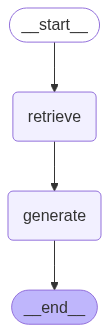

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='06b77b15-ee51-4e08-af41-370b31f46525', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 34990}, page_content='Conversatin samples:\n[\n  {\n    "role": "system",'), Document(id='17bf654d-977b-4803-9aff-230a329f71a5', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 34969}, page_content='pytest\ndataclasses'), Document(id='30960c87-2b76-4620-a1e6-95c356bb286e', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 35043}, page_content='"content": "You will get instructions for code to write.\\nYou will write a very long answer. Make sure that every detail of the architecture is, in the end, implemented as code.\\nMake sure that every detail of the architecture is, in the end, implemented as code.\\n\\nThink step by step and reason yourself to the right decisions to make sure we get it right.\\nYou will first lay out the names of the core classes

In [13]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='06b77b15-ee51-4e08-af41-370b31f46525', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 34990}, page_content='Conversatin samples:\n[\n  {\n    "role": "system",'), Document(id='17bf654d-977b-4803-9aff-230a329f71a5', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 34969}, page_content='pytest\ndataclasses'), Document(id='30960c87-2b76-4620-a1e6-95c356bb286e', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 35043}, page_content='"content": "You will get instructions for code to write.\\nYou will write a very long answer. Make sure that every detail of the architecture is, in the end, implemented as code.\\nMake sure that every detail of the architecture is, in the end, implemented as code.\\n\\nThink step by step and reason yourself to the right decisions to make sure we get it right.\\nYou will first lay out the names of 

In [14]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

Task| Decomposition| involves breaking down a complex task into smaller, more manageable subtasks. This allows for| a more structured and efficient approach to problem-solving. It is often used in| programming to organize code and improve readability.
|